In [1]:
import os 
import torch
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
from torchvision.transforms import v2
from PIL import Image
import sys


In [2]:
expand = 32
cond_path = f"t0.1/l0n_{expand}.npy"
uncond_path = f"t0.1/l0n_{expand}_uncond.npy"
dataset = ImageFolder("/home/yifulu/qq_turbo/imagenet/img10")

In [3]:
cond_np = np.load(cond_path)
uncond_np = np.load(uncond_path)

16504


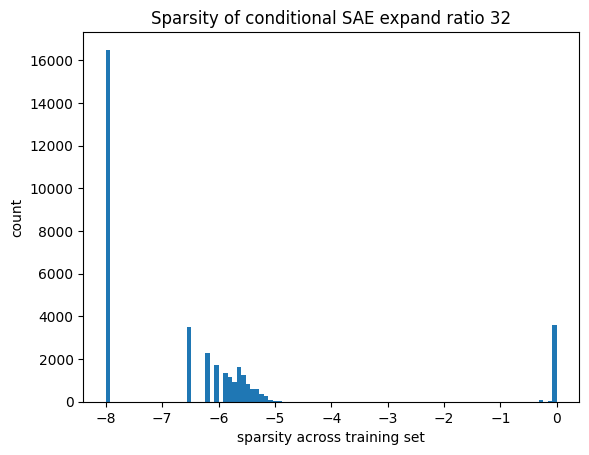

In [4]:
cl0n = cond_np/256/len(dataset)
plt.hist(np.log10(cl0n+1e-8), bins=100)
plt.title(f"Sparsity of conditional SAE expand ratio {expand}")
plt.xlabel("sparsity across training set")
plt.ylabel("count")
print((cl0n==0).sum().item())

17557


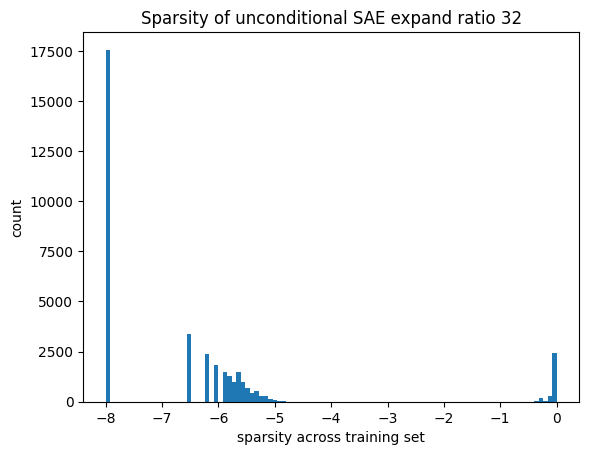

In [5]:
ucl0n = uncond_np/256/len(dataset)
plt.hist(np.log10(ucl0n+1e-8), bins=100)
plt.title(f"Sparsity of unconditional SAE expand ratio {expand}")
plt.xlabel("sparsity across training set")
plt.ylabel("count")
print((ucl0n==0).sum().item())

In [6]:
del cond_np
del uncond_np

In [7]:
lg10 = np.log10(cl0n+1e-8)
idx = np.logical_and(lg10 > -6 ,lg10 < -5)

In [ ]:
ind = np.where(idx)[0]
ind.sort()
np.set_printoptions(threshold=sys.maxsize)
print(ind)

In [9]:
feats_cond_32 = np.load("feats_cond_32.npy")

In [26]:
top4_dict = {}
for i in ind:
    # print(feats_cond_32[:,i].nonzero()[0].shape)
    top4 = np.argsort(feats_cond_32[:,i])[::-1][:4]
    top4_dict[i] = top4


In [11]:
# cond_feat_img_dict = {3:  [11821,   187,  6341, 12852,  8673,  8661,  8662,  8663,  8664,  8665,
#          8666,  8667,  8668,  8669,  8670,  8671],
# 11:[10748,  3329,  1559,  1506,   993,  8670,  8661,  8662,  8663,  8664,
#          8665,  8666,  8667,  8668,  8669,  8659],
# 12: [12819,  6554, 12831,  8873, 10663,  8932,  8101,  8670,  8672,  8669,
#          8668,  8667,  8666,  8665,  8664,  8663],
# 1183: [6035, 7458, 1135, 1216, 8672, 8660, 8661, 8662, 8663, 8664, 8665, 8666,
#         8667, 8668, 8669, 8670],
# 36867: [8767,  5880, 10851,  8873,  8671,  8660,  8661,  8662,  8663,  8664,
#          8665,  8666,  8667,  8668,  8669,  8670],
# 36861:[ 4016,  5982,  8180,  5686,  2416,  2623, 12410,  4290,  7643,  9105,
#          8671,  8664,  8670,  8669,  8668,  8667],
# 36862: [12013,  1422,  9751, 12074,  9911,   864,  7926, 11224, 12837,  8671,
#          8662,  8670,  8669,  8668,  8667,  8666]}

In [13]:

def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    https://github.com/openai/guided-diffusion/blob/8fb3ad9197f16bbc40620447b2742e13458d2831/guided_diffusion/image_datasets.py#L126
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])
transform = v2.Compose([
        v2.Lambda(lambda pil_image: center_crop_arr(pil_image, 256)),
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),  
        # v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
    ])

In [14]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

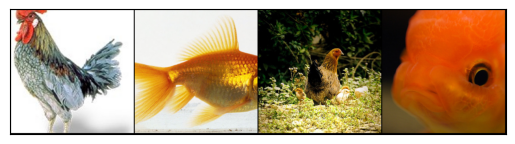

In [23]:
vis_img = [transform(dataset[x][0]) for x in top4_dict[36045]]
grid = make_grid(vis_img)
show(grid)

In [28]:
feats_uncond_32 = np.load("feats_uncond_32.npy")

In [ ]:
uclg10 = np.log10(ucl0n+1e-8)
idx = np.logical_and(uclg10 > -6 ,uclg10 < -5)
ind = np.where(idx)[0]
ind.sort()
print(ind)

In [32]:
top4_dict = {}
for i in ind:
    if len(feats_uncond_32[:,i].nonzero()[0]) < 4:
        continue
    top4 = np.argsort(feats_uncond_32[:,i])[::-1][:4]
    top4_dict[i] = top4


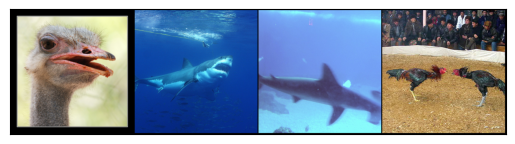

In [35]:
vis_img = [transform(dataset[x][0]) for x in top4_dict[620   ]]
grid = make_grid(vis_img)
show(grid)